In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

weirs = {
    "name": ["CSO_1", "CSO_10", "CSO_2", "CSO_20", "CSO_21"],
    "crest_level": [10.9, 10.62, 10.27, 10.79, 12.17],
    "discharge_coef": [1.34657, 1.34657, 1.34657, 1.34657, 1.34657],
    "length": [17, 19.8, 21.8, 9.5, 11.25],
}

pumps = {
    "name": [
        "WWWTP_inlet",
        "P_10_1",
        "P_2_1",
        "CSO_pump_2",
        "P_20_2",
        "P_21_2",
        "CSO_pump_21",
    ],
    "switch_on": [9.47, 8.61, 8.04, 10.29, 9.14, 10.26,  11.11],
    "switch_off": [9.17, 8.51, 7.89, 9.79, 8.99, 10.11,  10.91],
    "max_setpoint": [1.167, 0.694, 0.5, 0.5556, 0.015, 0.0417,  0.0278],
}


In [3]:
pump_data = pd.read_csv(
    "RTC/data/Dean Town Pump Data.csv",
    delimiter=",",
    index_col=0,
    parse_dates=True,
    names=pumps["name"],
    skiprows=1,
)
pump_data.index = pd.to_datetime(pump_data.index, format='mixed', dayfirst=True)

pump_data = pump_data * 15 * 60 # Integrate from flowrate to volume

head_data = pd.read_csv(
    "RTC/data/Dean Town Head Data.csv",
    delimiter=",",
    index_col=0,
    parse_dates=True,
    names=weirs["name"],
    skiprows=1,
)
head_data.index = pd.to_datetime(head_data.index, format='mixed', dayfirst=True)

cso_model_combined = pd.read_excel('RTC/data/model_data.xlsx', index_col=0, parse_dates=True)

In [4]:
def weir_formula(C, L, h, z):
    return C * L * (h - z) ** (3 / 2)

In [5]:
cso_data = head_data.copy()
for i, key in enumerate(cso_data.keys()):
    cso_data[key] = 0
    cso_data[key] = weir_formula(weirs['discharge_coef'][i], weirs['length'][i], \
        head_data[(head_data[key].values > weirs['crest_level'][i]).tolist()][key], weirs['crest_level'][i]) * 15 * 60

In [6]:
cso_data_combined = pd.concat([cso_data, pump_data[['CSO_pump_2', 'CSO_pump_21']]], axis=1).fillna(0)

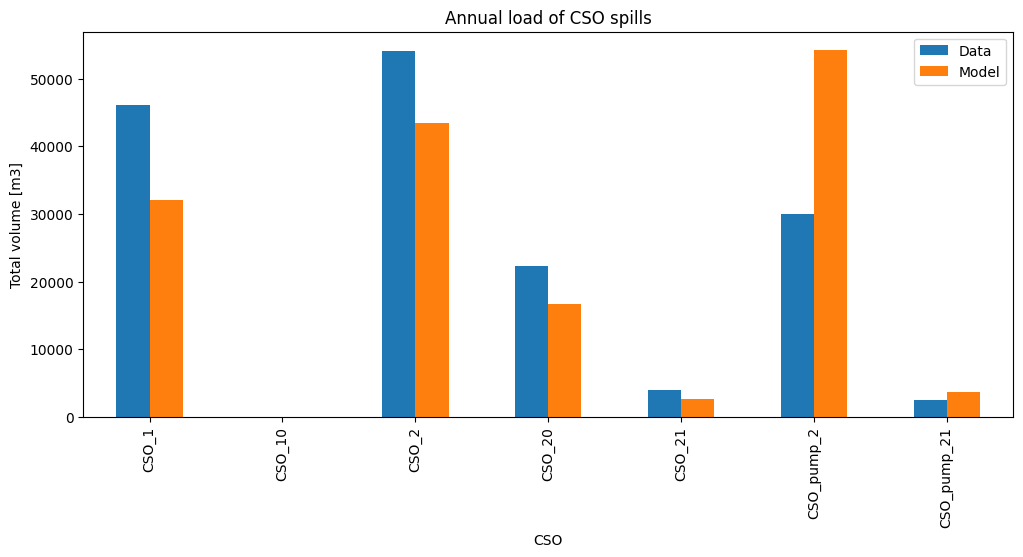

In [7]:
combined_data_summed = pd.concat([cso_data_combined.sum(), cso_model_combined.sum()], axis=1)
combined_data_summed.columns = ['Data', 'Model']

combined_data_summed.plot(kind='bar', figsize=(12, 5))
plt.xlabel('CSO')
plt.ylabel('Total volume [m3]')
plt.title('Annual load of CSO spills')
plt.show()

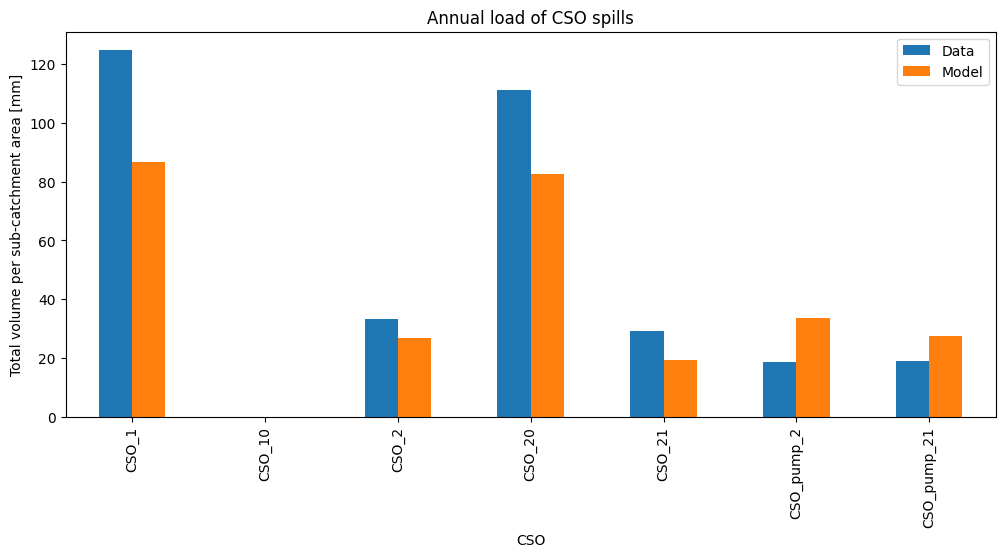

In [16]:
combined_data_summed = pd.concat([cso_data_combined.sum() / [370, 879, 1620, 201, 134, 1620, 134], cso_model_combined.sum() / [370, 879, 1620, 201, 134, 1620, 134]], axis=1)
combined_data_summed.columns = ['Data', 'Model']

combined_data_summed.plot(kind='bar', figsize=(12, 5))
plt.xlabel('CSO')
plt.ylabel('Total volume per sub-catchment area [mm]')
plt.title('Annual load of CSO spills')
plt.show()

In [13]:
cso_data_combined.sum() / [370, 879, 1620, 201, 134, 1620, 134]

CSO_1          124.811346
CSO_10           0.000000
CSO_2           33.425219
CSO_20         111.070426
CSO_21          29.260924
CSO_pump_2      18.518533
CSO_pump_21     18.843434
dtype: float64

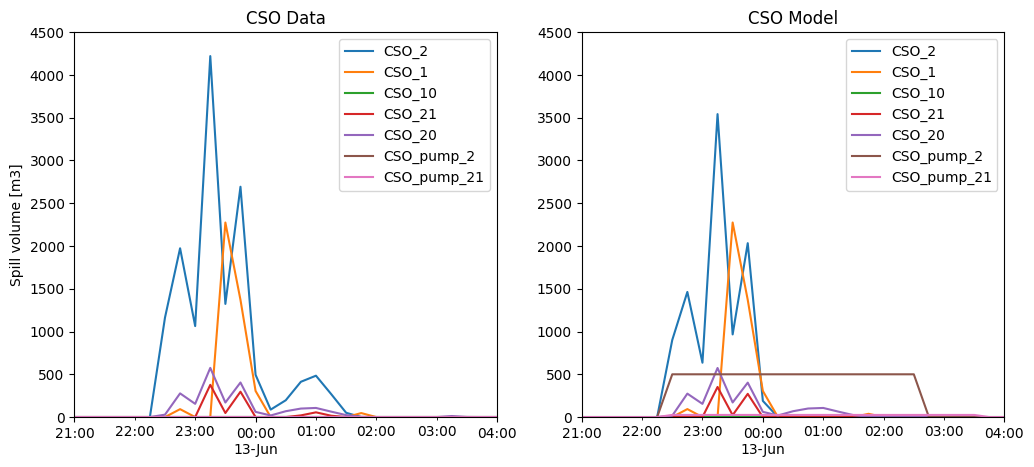

Data node CSO_2 spilled in total 14428.502 m3 between 12 and 13 june
Model node CSO_2 spilled in total 9728.558 m3 between 12 and 13 june
Data node CSO_1 spilled in total 4088.456 m3 between 12 and 13 june
Model node CSO_1 spilled in total 4080.964 m3 between 12 and 13 june
Data node CSO_10 spilled in total 0.000 m3 between 12 and 13 june
Model node CSO_10 spilled in total 0.000 m3 between 12 and 13 june
Data node CSO_21 spilled in total 811.784 m3 between 12 and 13 june
Model node CSO_21 spilled in total 645.848 m3 between 12 and 13 june
Data node CSO_20 spilled in total 2066.919 m3 between 12 and 13 june
Model node CSO_20 spilled in total 2050.589 m3 between 12 and 13 june
Data node CSO_pump_2 spilled in total 0.000 m3 between 12 and 13 june
Model node CSO_pump_2 spilled in total 8500.007 m3 between 12 and 13 june
Data node CSO_pump_21 spilled in total 0.000 m3 between 12 and 13 june
Model node CSO_pump_21 spilled in total 525.004 m3 between 12 and 13 june
The total volume spilled in

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
cso_data_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'][['CSO_2', 'CSO_1', 'CSO_10', 'CSO_21', 'CSO_20', 'CSO_pump_2', 'CSO_pump_21']].plot(ax =  ax[0], ylim=[0,4500])
ax[0].set_title('CSO Data')
cso_model_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'][['CSO_2', 'CSO_1', 'CSO_10', 'CSO_21', 'CSO_20', 'CSO_pump_2', 'CSO_pump_21']].plot(ax = ax[1], ylim=[0,4500])
ax[1].set_title('CSO Model')
ax[0].set_ylabel('Spill volume [m3]')
plt.show()

data_sum = 0
model_sum = 0
for node in ['CSO_2', 'CSO_1', 'CSO_10', 'CSO_21', 'CSO_20', 'CSO_pump_2', 'CSO_pump_21']:
    print(f"Data node {node} spilled in total {cso_data_combined.loc['2020-06-12 18:00':'2020-06-13 06:00'][node].sum():.3f} m3 between 12 and 13 june")
    print(f"Model node {node} spilled in total {cso_model_combined.loc['2020-06-12 18:00':'2020-06-13 06:00'][node].sum():.3f} m3 between 12 and 13 june")
    data_sum += cso_data_combined.loc['2020-06-12':'2020-06-13'][node].sum()
    model_sum += cso_model_combined.loc['2020-06-12':'2020-06-13'][node].sum()
print(f'The total volume spilled in data equals {data_sum:.3f}, and in the model {model_sum:.3f}, a difference of {data_sum-model_sum:.3f}')

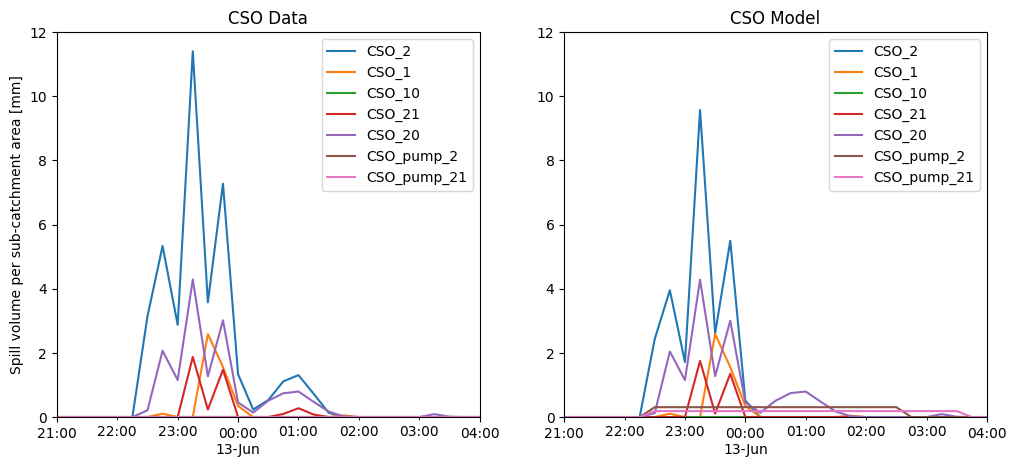

Data node CSO_2 spilled in total 14428.502 m3 between 12 and 13 june
Model node CSO_2 spilled in total 9728.558 m3 between 12 and 13 june
Data node CSO_1 spilled in total 4088.456 m3 between 12 and 13 june
Model node CSO_1 spilled in total 4080.964 m3 between 12 and 13 june
Data node CSO_10 spilled in total 0.000 m3 between 12 and 13 june
Model node CSO_10 spilled in total 0.000 m3 between 12 and 13 june
Data node CSO_21 spilled in total 811.784 m3 between 12 and 13 june
Model node CSO_21 spilled in total 645.848 m3 between 12 and 13 june
Data node CSO_20 spilled in total 2066.919 m3 between 12 and 13 june
Model node CSO_20 spilled in total 2050.589 m3 between 12 and 13 june
Data node CSO_pump_2 spilled in total 0.000 m3 between 12 and 13 june
Model node CSO_pump_2 spilled in total 8500.007 m3 between 12 and 13 june
Data node CSO_pump_21 spilled in total 0.000 m3 between 12 and 13 june
Model node CSO_pump_21 spilled in total 525.004 m3 between 12 and 13 june
The total volume spilled in

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
cso_data_combined_mm = cso_data_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'][['CSO_2', 'CSO_1', 'CSO_10', 'CSO_21', 'CSO_20', 'CSO_pump_2', 'CSO_pump_21']] / [370, 879, 1620, 201, 134, 1620, 134]
cso_data_combined_mm.plot(ax =  ax[0], ylim=[0,12])
ax[0].set_title('CSO Data')
cso_model_combined_mm = cso_model_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'][['CSO_2', 'CSO_1', 'CSO_10', 'CSO_21', 'CSO_20', 'CSO_pump_2', 'CSO_pump_21']] / [370, 879, 1620, 201, 134, 1620, 134]
cso_model_combined_mm.plot(ax = ax[1], ylim=[0,12])
ax[1].set_title('CSO Model')
ax[0].set_ylabel('Spill volume per sub-catchment area [mm]')
plt.show()

data_sum = 0
model_sum = 0
for node in ['CSO_2', 'CSO_1', 'CSO_10', 'CSO_21', 'CSO_20', 'CSO_pump_2', 'CSO_pump_21']:
    print(f"Data node {node} spilled in total {cso_data_combined.loc['2020-06-12 18:00':'2020-06-13 06:00'][node].sum():.3f} m3 between 12 and 13 june")
    print(f"Model node {node} spilled in total {cso_model_combined.loc['2020-06-12 18:00':'2020-06-13 06:00'][node].sum():.3f} m3 between 12 and 13 june")
    data_sum += cso_data_combined.loc['2020-06-12':'2020-06-13'][node].sum()
    model_sum += cso_model_combined.loc['2020-06-12':'2020-06-13'][node].sum()
print(f'The total volume spilled in data equals {data_sum:.3f}, and in the model {model_sum:.3f}, a difference of {data_sum-model_sum:.3f}')

In [10]:
print(cso_data_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'].sum())
print(cso_model_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'].sum())
print(cso_data_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'].sum().sum())
print(cso_model_combined.loc['2020-06-12 21:00':'2020-06-13 04:00'].sum().sum())

CSO_1           4088.456408
CSO_10             0.000000
CSO_2          14428.501648
CSO_20          2066.919323
CSO_21           811.784441
CSO_pump_2         0.000000
CSO_pump_21        0.000000
dtype: float64
CSO_1          4080.963515
CSO_10            0.000000
CSO_2          9728.557719
CSO_20         2050.589326
CSO_21          645.848349
CSO_pump_2     8500.006789
CSO_pump_21     525.004193
dtype: float64
21395.66182090552
25530.96989162732


In [11]:
print(cso_data_combined.sum())
print(cso_model_combined.sum())
print(cso_data_combined.sum().sum())
print(cso_model_combined.sum().sum())


CSO_1          46180.198198
CSO_10             0.000000
CSO_2          54148.854906
CSO_20         22325.155715
CSO_21          3920.963883
CSO_pump_2     30000.024181
CSO_pump_21     2525.020200
dtype: float64
CSO_1          32098.451599
CSO_10             0.000000
CSO_2          43409.378415
CSO_20         16631.849087
CSO_21          2588.473795
CSO_pump_2     54238.480809
CSO_pump_21     3675.029352
dtype: float64
159100.21708272607
152641.66305794538
